<h1>CNN model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h2>Helper functions to plot loss/accuracy, and build/train/test models.</h2>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features, 1))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=-1,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


In [5]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


<h4>Perform hyperparam tuning using the CNN layer(s)</h4>

In [7]:

number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    # don't add any dense layer
    dense_layers_unit_array = []
    
    conv_layers_filters_array=[]
    conv_kernel_size_array=[]
    conv_strides_array=[]
    
    conv_layers_filters_array_size = hp.Int('conv_layers_filters_array_size', min_value=1, max_value=4, step=1)
    for i in range(conv_layers_filters_array_size):
        conv_layers_filters_array.append(hp.Int('conv_layers_filters_'+str(i), 
                                                min_value=10, max_value=70, step=10))
        conv_kernel_size_array.append(hp.Int('conv_kernel_'+str(i), 
                                                min_value=2, max_value=5, step=1))
        conv_strides_array.append(hp.Int('conv_stride_'+str(i), 
                                          min_value=1, max_value=3, step=1))
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.01, 0.05, 0.1]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.7, step=0.1),
                startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),      
                optimizer=hp.Choice("optimizer", values=["Adam", "SGD"]),
                conv_layers_filters_array=conv_layers_filters_array,
                conv_kernel_size_array=conv_kernel_size_array,
                conv_strides_array=conv_strides_array     
                       )
    
    return model
                        
             

Trial 90 Complete [00h 02m 58s]
val_accuracy: 0.2529323697090149

Best val_accuracy So Far: 0.741951584815979
Total elapsed time: 01h 47m 33s
INFO:tensorflow:Oracle triggered exit
#### Hypertuning results:
learningRate: 0.05
isBatchNormalized: 1
dropOutRate: 0.1
conv_layers_filters_array_size: 2
conv_layers_filters_0: 60
conv_kernel_0: 4
conv_stride_0: 1
conv_layers_filters_1: 50
conv_kernel_1: 3
conv_stride_1: 2
conv_layers_filters_2: 70
conv_kernel_2: 2
conv_stride_2: 1
conv_layers_filters_0: 10
conv_kernel_3: 3
conv_stride_3: 3
dropOutRate: 0.1
#########################################

number_of_features: 3738
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_conv_layers: 2
conv_layer_filters[0]; unit:60
conv_kernel[0]; unit:4
conv_strides[0]; unit:1
conv_layer_filters[1]; unit:50
conv_kernel[1]; unit:3
conv_strides[1]; unit:2
learnin

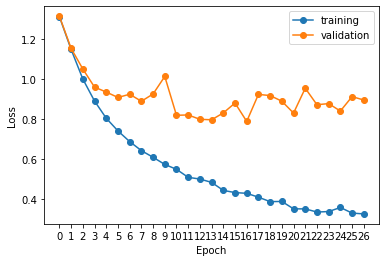

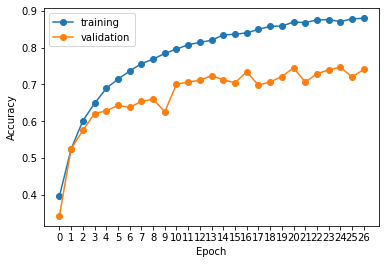

268/268 [==============================] - 2s 6ms/step - loss: 0.8596 - accuracy: 0.7460 - precision: 0.7731 - recall: 0.7238

Test Acc. 74.60%
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1978
           1       0.80      0.73      0.76      1957
           2       0.77      0.80      0.79      2069
           3       0.66      0.77      0.71      2011

   micro avg       0.75      0.75      0.75      8015
   macro avg       0.75      0.75      0.75      8015
weighted avg       0.75      0.75      0.75      8015
 samples avg       0.75      0.75      0.75      8015



In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

epochs = 40
tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=epochs,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")

print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))
print("conv_layers_filters_array_size:",best_hps.get('conv_layers_filters_array_size'))

try:
    print("conv_layers_filters_0:",best_hps.get('conv_layers_filters_0'))
    print("conv_kernel_0:",best_hps.get('conv_kernel_0'))
    print("conv_stride_0:",best_hps.get('conv_stride_0'))
except:
    print("no conv layer 0")
    
try:
    print("conv_layers_filters_1:",best_hps.get('conv_layers_filters_1'))
    print("conv_kernel_1:",best_hps.get('conv_kernel_1'))
    print("conv_stride_1:",best_hps.get('conv_stride_1'))
except:
    print("no conv layer 1")
    
try:
    print("conv_layers_filters_2:",best_hps.get('conv_layers_filters_2'))
    print("conv_kernel_2:",best_hps.get('conv_kernel_2'))
    print("conv_stride_2:",best_hps.get('conv_stride_2'))    
except:
    print("no conv layer 2")
    
try:
    print("conv_layers_filters_0:",best_hps.get('conv_layers_filters_3'))
    print("conv_kernel_3:",best_hps.get('conv_kernel_3'))
    print("conv_stride_3:",best_hps.get('conv_stride_3'))    
except:
    print("no conv layer 3")    

print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.2,
                     activation="tanh",
                     conv_layers_filters_array=[40],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[3]
                    )

<h1>Random runs to get a feel of the hyperparameters</h1>

Try 2 conv layers 50 filters each?

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50],
                     conv_kernel_size_array=[3,3],
                     conv_strides_array=[1,1]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50],
                     conv_kernel_size_array=[3],
                     conv_strides_array=[1]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50,50],
                     conv_kernel_size_array=[3,3,3],
                     conv_strides_array=[1,1,1]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     conv_layers_filters_array=[50,50,50,50],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1]
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="relu",
                     conv_layers_filters_array=[50,50,50,50],
                     conv_kernel_size_array=[3,3,3,3],
                     conv_strides_array=[1,1,1,1],
                     patience=20
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1920,1920], learningRate=0.2, optimizer="SGD",
                     startWithBatchNormalized=True,
                     conv_layers_filters_array=[96,32,32],
                    conv_kernel_size_array=[3,3,3],
                    conv_strides_array=[1,1,1]
                    )